# The Vestibular System - Part 2: 
# Sensory Transduction and Information Processing


<img src="data/images/labyrinth_labelled.png" style="width: 300px;"/>

## Preliminaries

The package **control** typically has to be installed by hand, with `pip install control` typed into a command terminal.

In [1]:
# Import the required packages
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import control

# Make the display easy to read
%precision 2

'%.2f'

## Geometry

### Canal-Muscle Alignment

We have three pairs of *semicircular canals (SCC)*, and three aligned pairs of *oculomotor muscles*. For example, the *horizontal semicircular canals* are aligned with the pulling directions of the *medial rectus* and the *abducens* muscles.

### Push-Pull Principle

Without stimulation, haircells have a *resting firing rate* of approx 100 Hz. But on inhibition, the firing rate cannot go below zero Hertz.
To achieve good bidirectional response, canals (and also otoliths) have to work in a *push-pull*
fashion. Activation of a canal on one side always inhibits the corresponding canal on the contralateral side. Comparison of the two canals determines the perception of rotation, with a linear response in both directions.
It is also explains the geometric arrangement of the six canals.

<img src="data/images/Semicircular_Canals.png" style="width: 250px;"/>

## Dynamics

To a good approximation, the dynamics of the balance system can be discribed with *linear time-invariant (LTI) systems*. Specifically, the mechanics of the SCCs can be well approximated by a damped oscillator. Since it is easier to visualize linear movements, we therefore first consider how to describe a linear damped oscillator.

### Damped Linear Oscillator Equations

The deflection of the cupula, the sensory element of the SCCs, as a function of head movement can be well approximated by the equations governing a *damped oscillator*.
(Details can be found in https://en.wikibooks.org/wiki/Sensory_Systems/Computer_Models/Vestibular_Simulation)

<img src="data/images/1D_movement.png" style="width: 300px;"/>

* x ... position of mass in space
* b ... position of base
* k ... spring constant
* $\delta = b - x$ ... difference

\begin{equation}
    m \ddot{x} = r \dot{\delta} + k * \delta
\end{equation}
\begin{equation}
    m \ddot{b} = m \ddot{\delta} + r \dot{\delta} + k * \delta
\end{equation}

### Implementation with Laplace Transformation

Differential equations like the one above can be converted into - easily solvable - algebraic equations, by making use of the *Laplace Transofmation*. Given any time course f(t), its Laplace transform F(s) is

\begin{equation}
  F(s) = \int\limits_0^\infty  {f(t) \cdot {e^{ - st}}dt}
\end{equation}
	
while its inverse is

\begin{equation}
  f(t) = \int\limits_S {F(s) \cdot {e^{st}}ds}
\end{equation}

where the integration is over the s-plane, S. s is sometimes referred to as *complex frequency*.

Laplace Transformations are a generalization of Fourier Transformation. With Fourier Transformations we have dealt only with sine waves, $e^{j \omega t}$ . Put another way, we have restricted $s$ to $j \omega$ so that est was restricted to $e^{j \omega t}$. But this is unnecessary, we can let $s$ enjoy being fully complex or $s = \sigma + j \omega$ . This greatly expands the kinds of functions that $e^{st}$ can represent.


With a Laplace transformation, where

\begin{equation}
    \frac{dx}{dt} \rightarrow s \tilde{X} - x(0)
\end{equation}
the differntial equation above is transformed into

\begin{equation}
    \frac{\delta}{sB} = \frac{m * s}{m s^2 + r s + k}
\end{equation}

#### Example: Kick a Damped Oscillator

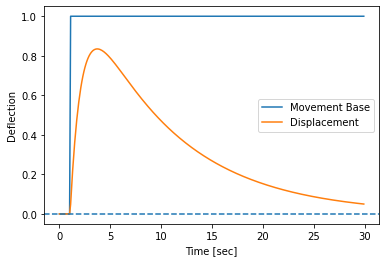

In [2]:
# Define the system parameters
m, r, k = 1, 1, 0.1

# Specify the transfer function, by giving the polynomial coefficients of numerator and denominator
num = [m, 0]
den = [m, r, k]
system = signal.lti(num, den)

# Define the input: here for example a velocity step, starting at t=1
t = np.arange(0, 30, 0.1)
x = np.zeros_like(t)
x[t>1] = 1

# Simulate the system response
t_out, out_signal, state_vector = signal.lsim(system, x, t)

# Plot the output
plt.plot(t, x, label='Movement Base')
plt.plot(t_out, out_signal, label='Displacement')
plt.legend()
plt.xlabel('Time [sec]')
plt.ylabel('Deflection')
plt.ylim(-0.05, 1.05)
plt.axhline(0, linestyle='--')

### Rotational Movements - SCC Dynamics

As shown in the wikibook, the deflection of the cupula of a SCC can be described well with a dampled oscillator. Thereby the parameters are such that the system can be approximated by a serial combination of low-pass filter and a high-pass filter. For typical head movements (i.e. movements with frequency components from 0.1 - 10 Hz), the deflection of the cupula is proportional to the head velocity ( https://en.wikibooks.org/wiki/Sensory_Systems/Computer_Models/Vestibular_Simulation )

<img src="data/images/cupula_deflected.png" style="width: 200px;"/>

Text(0.5, 0, 'Freqency [Hz]')

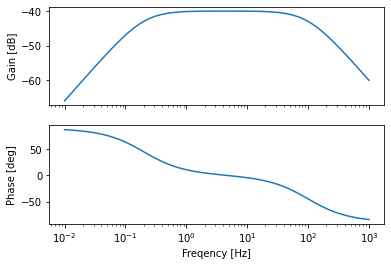

In [3]:
# SCC dynamics
T1 = 0.01  # time-constant for the low-pass filter (sec)
T2 = 5     # time-constant for the high-pass filter (sec)

num = [T1*T2, 0]
den = [T1*T2, T1+T2, 1]

# Find the bode-plot, which characterizes the system dynamics
scc = signal.lti(num,den)
w, mag, phase = signal.bode(scc)

# Plot the results
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].semilogx(w, mag)    # Bode magnitude plot
axs[0].set_ylabel('Gain [dB]')
axs[1].semilogx(w, phase)  # Bode phase plot
axs[1].set_ylabel('Phase [deg]')
axs[1].set_xlabel('Freqency [Hz]')

Now that we know the mechanical transfer function of the semicircular canals *scc*, we can simulate the deflection of the cupula for an arbitrary head movement with

In [4]:
head_movement = x
t_out, cupula_deflection, _ = signal.lsim(scc, head_movement, t)

## Information Processing by our Central Nervous System

From the analysis of the transduction mechanics (as described above), we know what the input to our nervous system is. And from the experimental recordings of human responses, e.g. eye movements during rotational accelerations in the dark, we know the resulting motor output. The signal analysis between is what happens "in the brain".

* Control system models can be used to describe the observed input-output behavior
* And through lesion experiments (in animal models, or in well-defined patients) we can try to locate the anatomical substrate corresponding to the control-system model


### Example 1: Internal model of the SCCs -> Velocity Storage

For example, experiments have revealed that the decay of the slow-phase eye velocity (and the corresponding perception of rotation) is significantly slower than the return of the cupula to its resting state. This extension of the time constant of the eye velocity can be simulated with a negative feedback loop. In the picture below, the elements with the "^" indicate the estimates, i.e. the internal models, of the true parameters; for example, *C* is the transfer function of the semicircular canal, and $\hat{C}$ the internal estimate of this transfer function:

<img src="data/images/Feedback_StateEstimation.png" width=400px>

\begin{gathered}
  \hat \omega  = ({S_{scc}} \cdot \omega ) \cdot k - {{\hat S}_{scc}} \cdot \hat \omega  \cdot k \hfill \\
  \hat \omega  = \frac{{({S_{scc}} \cdot \omega )}}{{{{\hat S}_{scc}} + \frac{1}{k}}}\,\,\xrightarrow{{k \to \infty }}\,\,\omega  \hfill \\ 
\end{gathered}

Such systems can be simulated in Python with the package *control* (unfortunately, it's syntax is slightly different from the one in scipy.signal):

In [5]:
# Canal response
scc = control.tf(num,den)
t_canal, deflection_cupula = control.step_response(scc)

# System response (i.e. eye movements), here with a feedback-gain of '1':
k = 1
feedback = control.series(scc, control.feedback(k, scc, sign=-1))
t_fb, x_fb = control.step_response(feedback)

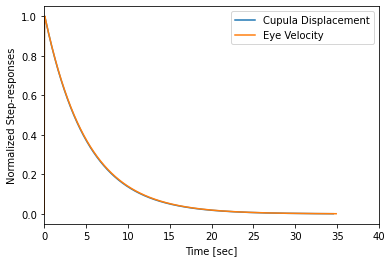

In [6]:
# Plot the results
plt.plot(t_canal, deflection_cupula/np.max(deflection_cupula), label='Cupula Displacement')
plt.plot(t_fb, x_fb/np.max(x_fb), label='Eye Velocity')
plt.xlim(0, 40)
plt.xlabel('Time [sec]')
plt.ylabel('Normalized Step-responses')
plt.legend()

### Anatomical correlate of this feedback loop
There exists physiological confirmation for the actual existance of such feedback loops: when the *corpus callosum* is severed, or in patients with *unilateral vestibular deafferentation*, the time constant of the eye velocity corresponds approximatley

### Example 2: Neural Integrator (only oculomotor, no vestibular component)

Healthy humans are also able to move the eye into an eccentric eye position - and keep them there:

<img src="data/images/Neural_Integrator.png" style="width: 500px;"/>

To generate the constant neural input required to *keep* the eye in an eccentric position, we need a *neural integrator* to obtain an *eye position* signal:

<img src="data/images/Neural-Integrator.gif" style="width: 500px;"/>

For horizontal eye movements, this integrator can be found in the *nucleus prepositus hypoglossi*; and for vertical/torsional eye movements, this integrator is located in the *nucleus of Cajal*.

[Vestibular_2_Stimulus.ipynb](Vestibular_1_FirstComputationalSteps.ipynb)<img src="data/images/Forward_Backward.png" align="middle"> [Vestibular_4_TipsForExercise.ipynb](Vestibular_4_TipsForExercise.ipynb)

    Author: Thomas Haslwanter
    Date: Feb 16, 2023

<img src="data/images/CCA_40.png">
*The Vestibular System*  is licensed under a Creative Commons Attribution 4.0 International License.